In [61]:
# import libraries here:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn import cluster
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
# from textblob import TextBlob, Word
# from nltk.stem.snowball import SnowballStemmer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
%matplotlib inline

In [2]:
data = pd.read_csv('data_MCF_combined_1-180.csv')
data.job_title = data.job_title.str.lower()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3744 entries, 0 to 3743
Data columns (total 14 columns):
company                       3744 non-null object
job_title                     3744 non-null object
location                      3744 non-null object
employment_type               3744 non-null object
position_type                 3744 non-null object
category                      3744 non-null object
gov_support_available         3744 non-null object
salary_low_rng                3259 non-null float64
salary_high_rng               3259 non-null float64
salary_median                 0 non-null float64
salary_type                   3259 non-null object
closing_date                  3744 non-null object
roles_and_responsibilities    3744 non-null object
requirements                  3744 non-null object
dtypes: float64(3), object(11)
memory usage: 409.6+ KB


In [3]:
# parse only data science related jobs
keywords = 'analyst|data|data scientist|ai|software|dev|learning|analytics|research|cloud|.net|stack|technical support|language'
ds_data = data[data.job_title.str.contains(keywords)].copy()

# get the median salary from low and high salary range
ds_data['salary_median'] = (ds_data.salary_high_rng.values + ds_data.salary_low_rng.values)/2

# drop any data entry position
ds_data.drop(ds_data[ds_data.job_title.str.contains('clerk|entry')].index,inplace=True)

# # change all annual salary to monthly salary
ds_data.iloc[:,10].replace('Annually','Monthly',inplace=True)

# find out how many positions do not disclose any salary ranges
counter = ds_data.loc[ds_data.salary_low_rng.isnull()]['position_type'].count()
print ('Out of {} entires, there are {} entries with undisclosed salary'.format(len(ds_data),counter))

# separate out null to become 'unseen' set
ds_data_null = ds_data[ds_data['salary_low_rng'].isnull()].copy()

# use this as train test split dataset
ds_data_not_null = ds_data[~ds_data['salary_low_rng'].isnull()].copy()


Out of 1392 entires, there are 138 entries with undisclosed salary


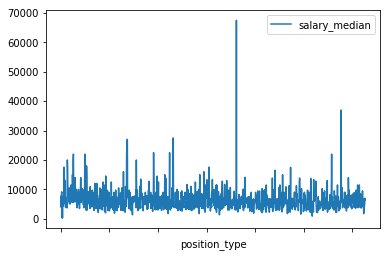

In [4]:
# check graphically the median salary distribution
ds_data_not_null.plot.line(x='position_type',y='salary_median')

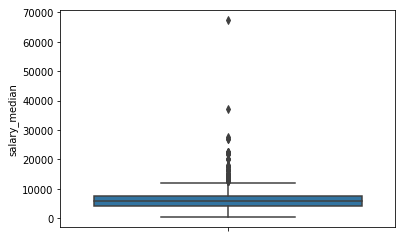

In [5]:
sns.boxplot(data=ds_data_not_null,x='salary_median',orient='v')

In [6]:
# calculating salary brackets
mean = ds_data_not_null.salary_median.mean()
std = ds_data_not_null.salary_median.std()
entry_lvl = mean - 0.5*std
mid_lvl = entry_lvl + std
low_lvl = mean-1.5*std
ultra_high_lvl = mean + 1.5*std
entry_lvl,mid_lvl,ultra_high_lvl

(4547.321460220707, 8229.320352659674, 11911.319245098643)

In [7]:
# drop outlier with error information
ds_data_not_null.drop(ds_data_not_null.loc[(ds_data_not_null.salary_median>35000)].index,inplace=True)
# drop lower percentile outlier that are not ds related position:
ds_data_not_null.drop(ds_data_not_null.loc[ds_data_not_null.salary_median<low_lvl].index,inplace=True)

In [8]:
# give category for the salaries based on standard deviation brackets

# entry = salary up to 4.5k
a = ds_data_not_null.loc[(ds_data_not_null.salary_median>low_lvl)&(ds_data_not_null.salary_median<entry_lvl)].copy()
# mid = salary between 4.5k to 8.2k 
b = ds_data_not_null.loc[(ds_data_not_null.salary_median>entry_lvl)&(ds_data_not_null.salary_median<mid_lvl)].copy()
# high = salary between 8.2k to 12k
c = ds_data_not_null.loc[(ds_data_not_null.salary_median>mid_lvl)&(ds_data_not_null.salary_median<ultra_high_lvl)].copy()
# very high = salary above 12k
d = ds_data_not_null.loc[(ds_data_not_null.salary_median>ultra_high_lvl)].copy()

# entry = 0, mid = 1, high = 2,very high = 3
a['salary_category']=0
b['salary_category']=1
c['salary_category']=2
d['salary_category']=3
frames = [a,b,c,d]

# return everything back to original df 
ds_data_not_null = pd.concat(frames)

In [9]:
y = ds_data_not_null.salary_category
X = ds_data_not_null.iloc[:,7:9+1].copy()
X = MinMaxScaler().fit_transform(X)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=44)

## Question 1

### Using K-Means clustering to predict salary category

In [10]:
# Using KMeans to cluster salary grouping
from sklearn.cluster import KMeans
k_mean = KMeans(n_clusters=4)
k_mean.fit(X)
labels = k_mean.labels_
clusters = k_mean.cluster_centers_

from sklearn.metrics import silhouette_score
silhouette_score(X,labels)

0.5028389464484707

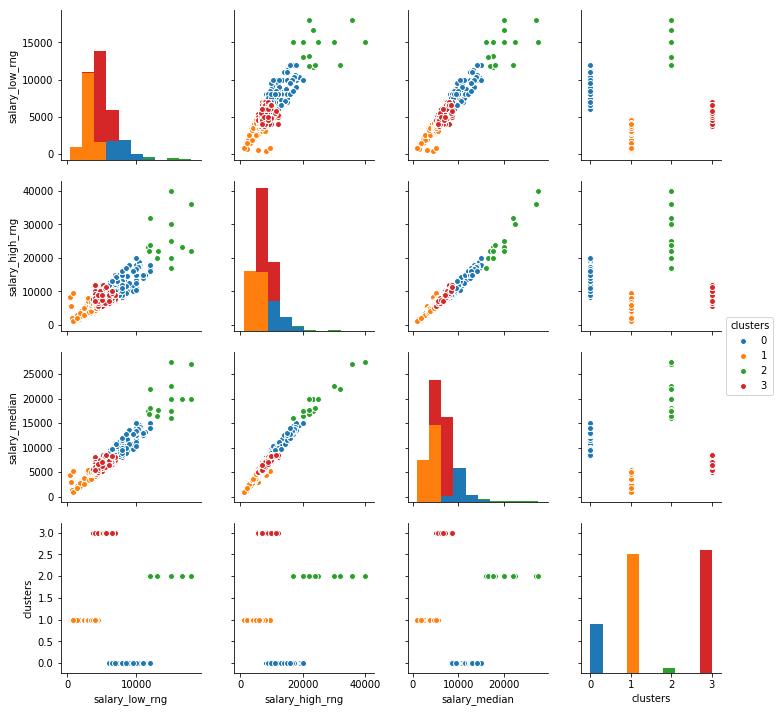

In [11]:
# visualising clustering results on predictor variables
X_4 = ds_data_not_null.iloc[:,7:9+1].copy()
X_4['clusters'] = labels
sns.pairplot(data=X_4, hue='clusters')

### Using NLP (CountVectorizer) to identify words and use Logistic Regression to predict salary category

In [12]:
y = ds_data_not_null.salary_category
X_rqmt = ds_data_not_null.requirements

X_train,X_test,y_train,y_test = train_test_split(X_rqmt,y,test_size=0.3,random_state=44)

# Using countvectorizer to clean the text
vect = CountVectorizer(decode_error='replace',ngram_range= (1,3),strip_accents='unicode',stop_words='english')
X_train = vect.fit_transform(X_train)

# do up a count summary of the words appearing in 'requirement'
word_counts = pd.DataFrame(X_train.todense(), columns = vect.get_feature_names())
summary = word_counts.sum(axis=0).sort_values(ascending = False).head(40)

X_test = vect.transform(X_test)

# apply logistic regression and check score
lr = LogisticRegression()
lr.fit(X_train, y_train)
score = lr.score(X_test, y_test)

print ('no. of features: {}'.format(len(vect.get_feature_names())))
print ('scoring for logistic regression: {}'.format(score))

no. of features: 88656
scoring for logistic regression: 0.618666666667


### Using Random Forest to predict the salary category

In [13]:
y = ds_data_not_null.salary_category
X = ds_data_not_null.iloc[:,:9+1]

In [14]:
# most of the predictor variables are string. Assign encoded label to each sample
le = LabelEncoder()
def encoding(df,df_columns):
    le.fit(df[df_columns])
    temp = le.transform(df[df_columns])
    return temp

# Hard code all the encoded labels into a new DataFrame
a=pd.DataFrame(encoding(ds_data_not_null,'company'),columns=['company'])
b=pd.DataFrame(encoding(ds_data_not_null,'job_title'),columns=['job_title'])
c=pd.DataFrame(encoding(ds_data_not_null,'employment_type'),columns=['employment_type'])
d=pd.DataFrame(encoding(ds_data_not_null,'position_type'),columns=['position_type'])
e=pd.DataFrame(encoding(ds_data_not_null,'category'),columns=['category'])
f=pd.DataFrame(encoding(ds_data_not_null,'gov_support_available'),columns=['gov_support_available'])
g=pd.DataFrame(encoding(ds_data_not_null,'location'),columns=['location'])
frames = [b,c,d,e,f,g]

new_X=a.join(frames)

# tired this method but gives me a shape error when fitted into the random forest model
# new_y=pd.DataFrame(encoding('salary_category'),columns=['salary_category'])

In [15]:
# split dataset into test and training dataset
Xtrain, Xtest, ytrain, ytest = train_test_split(new_X, y, test_size=0.33)

# using Decision Tree model
dtc = DecisionTreeClassifier(max_depth=None, max_features='auto')
dtc.fit(Xtrain, ytrain)
print 'dtc acc:', dtc.score(Xtest, ytest)

# using Random Forest model
rf = RandomForestClassifier(n_estimators=4400, max_depth=None, max_features='auto',n_jobs=-1)
rf.fit(Xtrain, ytrain)
yhat = rf.predict(Xtest)
print 'rf acc:', accuracy_score(ytest, yhat)

dtc acc: 0.49878934624697335
rf acc: 0.5690072639225182


In [16]:
# take a look which features have the highest importances value:
feature_impt = pd.Series(rf.feature_importances_,index=Xtrain.columns)
feature_impt

# random forest at best gives an accuracy score of 0.55 with more importance on the company and job title.
# a way to increase the accuracy is to 'clean' or standardise the way job title is being named.
# previous test when ran with median salary yield a 0.997 score. this is subsequently removed. 

company                  0.250108
job_title                0.270004
employment_type          0.088846
position_type            0.122068
category                 0.147836
gov_support_available    0.034673
location                 0.086465
dtype: float64

## Question 2

In [17]:
data_scientist = ds_data_not_null.loc[ds_data.job_title.str.contains('data scientist|research scientist|associate|fellow')].copy()
data_engineer = ds_data_not_null.loc[(ds_data.job_title.str.contains('data engineer|research engineer|software engineer|data center'))].copy()
data_analyst = ds_data_not_null.loc[(ds_data.job_title.str.contains('data analyst|business analyst|analytics'))].copy()

data_scientist['label'] = 'scientist'
data_engineer['label'] = 'engineer'
data_analyst['label'] = 'analyst'

ds_df = pd.concat([data_analyst,data_engineer,data_scientist])

print ('no. of data scientist: {}'.format(len(data_scientist)))
print ('no. of data engineer: {}'.format(len(data_engineer)))
print ('no. of data analyst: {}'.format(len(data_analyst)))

no. of data scientist: 187
no. of data engineer: 165
no. of data analyst: 196


In [68]:
y = ds_df.label
X_rqmt = ds_df.requirements

X_train,X_test,y_train,y_test = train_test_split(X_rqmt,y,test_size=0.3,random_state=44)

# MultinomialNB
pipeline = Pipeline([
    ('vect', CountVectorizer(lowercase=True, strip_accents='unicode', decode_error='replace', stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('cls', lr)
]) 
pipeline.fit(X_train, y_train)
predicted = pipeline.predict(X_test)
pipeline.score(X_test, y_test)

0.7454545454545455

In [73]:
y = ds_df.label
X_rqmt = ds_df.requirements

X_train,X_test,y_train,y_test = train_test_split(X_rqmt,y,test_size=0.3,random_state=44)
                                                 
pipeline = Pipeline([
    ('vect', CountVectorizer(lowercase=True, strip_accents='unicode', decode_error='replace', stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('rf', RandomForestClassifier(n_estimators=1000))
]) 
pipeline.fit(X_train, y_train)
predicted = pipeline.predict(X_test)
pipeline.score(X_test, y_test)

0.7272727272727273